# Levels.fyi Software Engineer Compensation

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import itertools

import sklearn.linear_model as skl_lm
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

import statsmodels.api as sm
import matplotlib.pyplot as plt

import seaborn as sns

from patsy import dmatrix

pd.set_option('display.max_rows', 100)
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
comp = pd.read_csv('compensation.csv')
comp.dtypes
comp.head(10)

Date                          object
Company                       object
Title                         object
Level                         object
Standard Level                object
Skill Index                  float64
Location                      object
Total Yearly Compensation      int64
Base Salary (/year)          float64
Stock Grant (/year)          float64
Bonus (/year)                float64
Years of Experience            int64
Years at Company             float64
Tag                           object
Gender                        object
Other Details                 object
dtype: object

,Date,Company,Title,Level,Standard Level,Skill Index,Location,Total Yearly Compensation,Base Salary (/year),Stock Grant (/year),Bonus (/year),Years of Experience,Years at Company,Tag,Gender,Other Details
0,2/5/2020,JPMorgan Chase,Software Engineer,Senior Associate,Software Engineer,28.57,"London, EN, United Kingdom",87000,78000.0,NaN,9000.0,3,1.0,Full Stack,Male,NaN
1,2/5/2020,TripAdvisor,Software Engineer,Principal Software Engineer,NaN,NaN,"Oxford, EN, United Kingdom",212000,121000.0,70000.0,21000.0,17,4.0,Distributed Systems (Back-End),Male,NaN
2,2/5/2020,Salesforce,Software Engineer,Lead MTS,Senior Engineer,61.00,"San Francisco, CA",275000,200000.0,45000.0,30000.0,14,1.0,Testing (SDET),Male,NaN
3,2/5/2020,Adobe,Software Engineer,Senior Software Engineer (5),Senior Engineer,44.55,"San Jose, CA",270000,190000.0,60000.0,20000.0,12,1.0,Distributed Systems (Back-End),NaN,NaN
4,2/5/2020,Rokt,Software Engineer,L3,NaN,NaN,"Sydney, NS, Australia",133000,115000.0,10000.0,8000.0,2,1.0,Web Development (Front-End),Male,NaN
5,2/5/2020,Turbonomic,Software Engineer,Senior,NaN,NaN,"New York, NY",180000,155000.0,NaN,25000.0,5,2.0,Web Development (Front-End),Male,Masters
6,2/5/2020,Salesforce,Software Engineer,Senior MTS,Senior Engineer,44.50,"San Francisco, CA",192000,177000.0,NaN,15000.0,12,4.0,Full Stack,Male,Masters
7,2/5/2020,Uber,Software Engineer,Senior Software Engineer,Senior Engineer,50.00,"San Francisco, CA",250000,162000.0,72000.0,16000.0,4,4.0,Distributed Systems (Back-End),Male,NaN
8,2/5/2020,Amazon,Software Engineer,SDE I,Entry Level Engineer,10.87,"Seattle, WA",158000,112000.0,20000.0,26000.0,0,0.0,Distributed Systems (Back-End),Female,Masters
9,2/5/2020,Amazon,Software Engineer,Principal SDE,Staff Engineer,75.00,"Toronto, ON, Canada",343000,165000.0,178000.0,0.0,36,2.0,Distributed Systems (Back-End),Male,NaN


## Data Cleaning

In [4]:
def comp_tidy_cols(comp):
    # Make column names nicer
    comp.columns = map(str.lower, comp.columns.str.replace(' ', '_'))
    comp.rename(columns={
        'total_yearly_compensation': 'total_comp',
        'base_salary_(/year)': 'salary',
        'stock_grant_(/year)': 'stock',
        'bonus_(/year)': 'bonus',
        'years_of_experience': 'years_experience',
        'years_at_company': 'years_company',
    }, inplace=True)

    # Title: All entries is "Software Engineer" so this isn't particularly useful info 
    # Standard Level & Skill Index: Columns are determined by Levels.fyi; preferable not to confound results based on blackbox algorithm
    # Date: Unlikely to do time-series analysis, so will simply drop date at this stage
    comp.drop(columns=['standard_level', 'skill_index', 'date', 'title'], inplace=True, errors='ignore')

    return comp
    
comp = comp_tidy_cols(comp)
comp.head()

,company,level,location,total_comp,salary,stock,bonus,years_experience,years_company,tag,gender,other_details
0,JPMorgan Chase,Senior Associate,"London, EN, United Kingdom",87000,78000.0,NaN,9000.0,3,1.0,Full Stack,Male,NaN
1,TripAdvisor,Principal Software Engineer,"Oxford, EN, United Kingdom",212000,121000.0,70000.0,21000.0,17,4.0,Distributed Systems (Back-End),Male,NaN
2,Salesforce,Lead MTS,"San Francisco, CA",275000,200000.0,45000.0,30000.0,14,1.0,Testing (SDET),Male,NaN
3,Adobe,Senior Software Engineer (5),"San Jose, CA",270000,190000.0,60000.0,20000.0,12,1.0,Distributed Systems (Back-End),NaN,NaN
4,Rokt,L3,"Sydney, NS, Australia",133000,115000.0,10000.0,8000.0,2,1.0,Web Development (Front-End),Male,NaN


In [5]:
comp.isna().sum(axis=0)

company               0
level                 0
location              0
total_comp            0
salary               20
stock               163
bonus                29
years_experience      0
years_company         0
tag                   0
gender               96
other_details       335
dtype: int64

In [6]:
def comp_fill_vals(comp):
    if 'salary' in comp:
        comp.salary.replace(to_replace = np.NaN, value = comp.total_comp, inplace = True)
    else:
        comp.salary = 0        
        
    if 'stock' in comp:
        comp.stock.replace(to_replace = np.NaN, value = 0.0, inplace = True)
    else:
        comp.stock = 0
        
    if 'bonus' in comp:
        comp.bonus.replace(to_replace = np.NaN, value = 0.0, inplace = True)
    else:
        comp.bonus = 0
        
    if 'gender' in comp:
        comp.gender.replace(to_replace = np.NaN, value = 'Unknown', inplace = True)
    else:
        comp.gender = 'Unknown'
        
    if 'other_details' in comp:
        comp.other_details.replace(to_replace = np.NaN, value = '', inplace = True)
    else:
        comp.other_details = ''

    return comp

comp = comp_fill_vals(comp)
comp.isna().sum(axis=0)

company             0
level               0
location            0
total_comp          0
salary              0
stock               0
bonus               0
years_experience    0
years_company       0
tag                 0
gender              0
other_details       0
dtype: int64

In [7]:
def comp_scale_dollars(comp):
    # Scale down dollar values for clarity, so they appear in the thousands
    comp_total_comp = comp.total_comp / 1000
    comp_salary = comp.salary / 1000
    comp_stock = comp.stock / 1000
    comp_bonus = comp.bonus / 1000
    
    comp.total_comp = comp.total_comp / 1000
    comp.salary = comp.salary / 1000
    comp.stock = comp.stock / 1000
    comp.bonus = comp.bonus / 1000
    
    return comp, comp_total_comp, comp_salary, comp_stock, comp_bonus

comp, y_total_comp, y_salary, y_stock, y_bonus = comp_scale_dollars(comp)
comp_clean = comp.copy(deep=True)
comp

,company,level,location,total_comp,salary,stock,bonus,years_experience,years_company,tag,gender,other_details
0,JPMorgan Chase,Senior Associate,"London, EN, United Kingdom",87.0,78.0,0.0,9.0,3,1.0,Full Stack,Male,
1,TripAdvisor,Principal Software Engineer,"Oxford, EN, United Kingdom",212.0,121.0,70.0,21.0,17,4.0,Distributed Systems (Back-End),Male,
2,Salesforce,Lead MTS,"San Francisco, CA",275.0,200.0,45.0,30.0,14,1.0,Testing (SDET),Male,
3,Adobe,Senior Software Engineer (5),"San Jose, CA",270.0,190.0,60.0,20.0,12,1.0,Distributed Systems (Back-End),Unknown,
4,Rokt,L3,"Sydney, NS, Australia",133.0,115.0,10.0,8.0,2,1.0,Web Development (Front-End),Male,
...,...,...,...,...,...,...,...,...,...,...,...,...
494,VMware,P5,"Palo Alto, CA",170.0,170.0,0.0,0.0,16,7.0,API Development (Back-End),Unknown,
495,Facebook,E5,"Menlo Park, CA",345.0,183.0,135.0,27.0,5,1.0,Full Stack,Male,
496,Accenture,Software Engineer Analyst,"Washington, DC",78.0,78.0,0.0,0.0,0,0.0,DevOps,Male,
497,Zillow,P2,"Seattle, WA",172.0,140.0,25.0,7.0,2,0.0,ML / AI,Male,


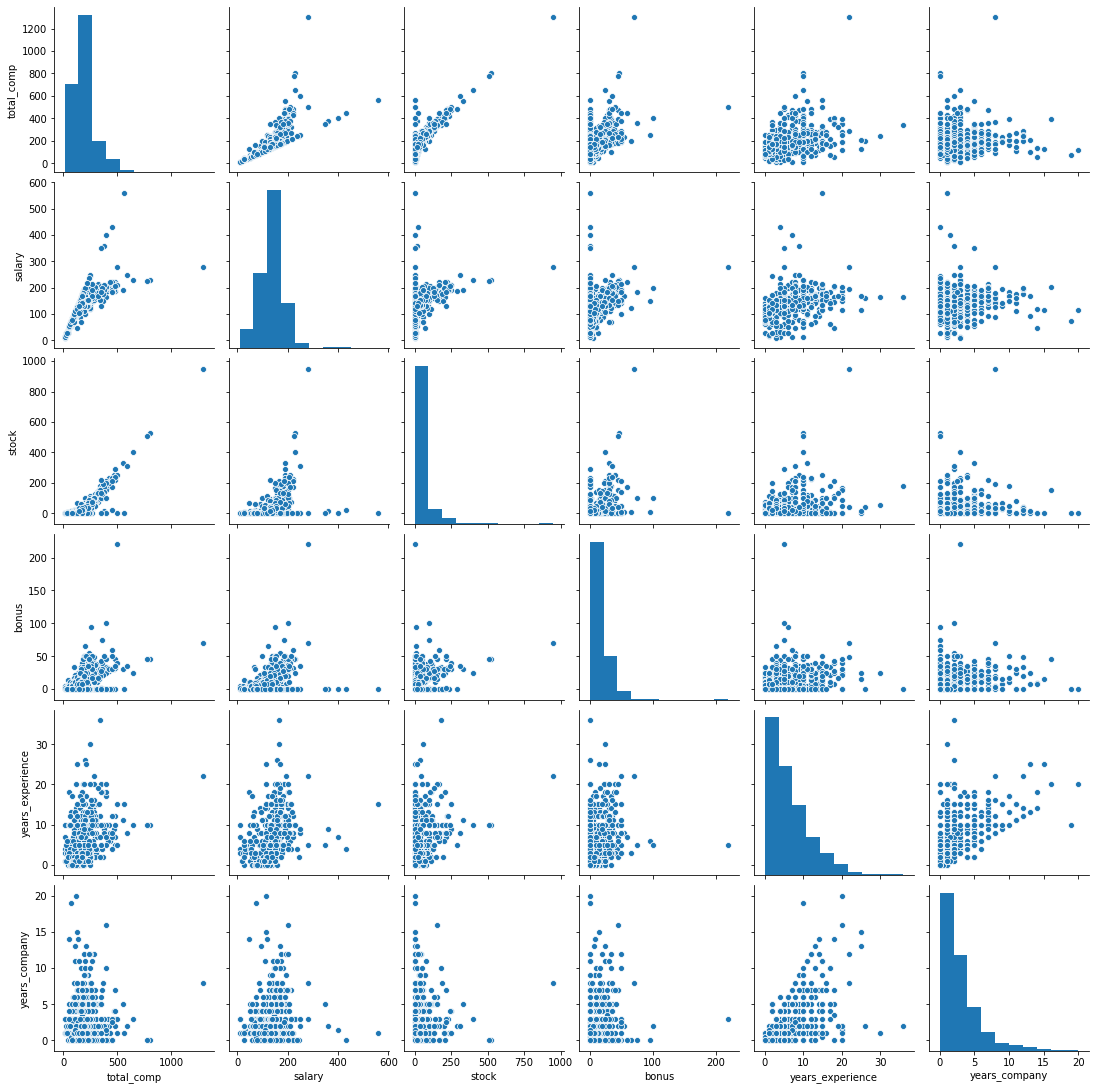

In [8]:
sns.pairplot(comp[['total_comp', 'salary', 'stock', 'bonus', 'years_experience', 'years_company']])
# sns.pairplot(comp[['years_experience', 'years_company', 'salary']])

In [9]:
# comp_faang = comp.company.str.contains('Google|Facebook|Apple|Amazon|Microsoft', regex=True)
# graph = sns.boxplot(x='company', y='salary', data=comp[comp_faang],
#                     order=['Amazon', 'Microsoft', 'Apple', 'Google', 'Facebook'],
#                     palette={
#                         'Facebook': 'blue',
#                         'Google': 'green',
#                         'Microsoft': 'brown',
#                         'Amazon': 'orange',
#                         'Apple': 'purple'})
# graph.axhline(comp.salary.median(), color='red', ls='--')
# plt.ylim(75, 250)
# plt.xlabel('')

In [10]:
def comp_create_dummies(comp, stringent=True, interaction=True):
    if interaction:
        # Note! This create dummies for only those combinations that exist in the data, not all combinations!
        comp["company_level"] = comp["company"] + "_" + comp["level"]
        dummies_company_levels = dmatrix("0 + company_level", comp, return_type='dataframe')
        comp = pd.concat([comp, dummies_company_levels], axis=1)

        comp["company_location"] = comp["company"] + "_" + comp["location"]
        dummies_company_location = dmatrix("company_location", comp, return_type='dataframe')
        comp = pd.concat([comp, dummies_company_location], axis=1)
    else:
        # Heuristically select the companies with 5 or more data points
        dummies_companies = pd.get_dummies(comp.company)
        filtered_companies = comp.company.value_counts()
        if stringent:
            filtered_companies = filtered_companies[filtered_companies >= 5]
        comp = comp.join(dummies_companies[filtered_companies.index], rsuffix='_company')
        
        # Heuristically select the level with 5 or more data points
        dummies_levels = pd.get_dummies(comp.level)
        filtered_levels = comp.level.value_counts()
        if stringent:
            filtered_levels = filtered_levels[filtered_levels >= 5]
        comp = comp.join(dummies_levels[filtered_levels.index], rsuffix='_level')

    # Heuristically select the locations with 5 or more data points
    dummies_locations = pd.get_dummies(comp.location)
    filtered_locations = comp.location.value_counts()
    if stringent:
        filtered_locations = filtered_locations[filtered_locations >= 5]
    comp = comp.join(dummies_locations[filtered_locations.index], rsuffix='_location')
        
    # Heuristically select those tags with more than 1 data points
    dummies_tags = pd.get_dummies(comp.tag)
    filtered_tags = comp.tag.value_counts()
    if stringent:
        filtered_tags = filtered_tags[filtered_tags >= 2]
    comp = comp.join(dummies_tags[filtered_tags.index], rsuffix='_tag')

    # Use all gender values
    dummies_genders = pd.get_dummies(comp[['gender']])
    comp = pd.concat([comp, dummies_genders], axis=1)

    # Manually create dummies based on other details
    comp['masters'] = comp.other_details.str.lower().str.contains('master').factorize()[0]
    comp['phd'] = comp.other_details.str.lower().str.contains('phd').factorize()[0]
        
    return comp

comp = comp_create_dummies(comp)
comp.head(15)

,company,level,location,total_comp,salary,stock,bonus,years_experience,years_company,tag,...,Android,Site Reliability (SRE),Security,Mobile (iOS + Android),gender_Female,gender_Male,gender_Other,gender_Unknown,masters,phd
0,JPMorgan Chase,Senior Associate,"London, EN, United Kingdom",87.0,78.0,0.0,9.0,3,1.0,Full Stack,...,0,0,0,0,0,1,0,0,0,0
1,TripAdvisor,Principal Software Engineer,"Oxford, EN, United Kingdom",212.0,121.0,70.0,21.0,17,4.0,Distributed Systems (Back-End),...,0,0,0,0,0,1,0,0,0,0
2,Salesforce,Lead MTS,"San Francisco, CA",275.0,200.0,45.0,30.0,14,1.0,Testing (SDET),...,0,0,0,0,0,1,0,0,0,0
3,Adobe,Senior Software Engineer (5),"San Jose, CA",270.0,190.0,60.0,20.0,12,1.0,Distributed Systems (Back-End),...,0,0,0,0,0,0,0,1,0,0
4,Rokt,L3,"Sydney, NS, Australia",133.0,115.0,10.0,8.0,2,1.0,Web Development (Front-End),...,0,0,0,0,0,1,0,0,0,0
5,Turbonomic,Senior,"New York, NY",180.0,155.0,0.0,25.0,5,2.0,Web Development (Front-End),...,0,0,0,0,0,1,0,0,1,0
6,Salesforce,Senior MTS,"San Francisco, CA",192.0,177.0,0.0,15.0,12,4.0,Full Stack,...,0,0,0,0,0,1,0,0,1,0
7,Uber,Senior Software Engineer,"San Francisco, CA",250.0,162.0,72.0,16.0,4,4.0,Distributed Systems (Back-End),...,0,0,0,0,0,1,0,0,0,0
8,Amazon,SDE I,"Seattle, WA",158.0,112.0,20.0,26.0,0,0.0,Distributed Systems (Back-End),...,0,0,0,0,1,0,0,0,1,0
9,Amazon,Principal SDE,"Toronto, ON, Canada",343.0,165.0,178.0,0.0,36,2.0,Distributed Systems (Back-End),...,0,0,0,0,0,1,0,0,0,0


In [11]:
def comp_drop_cols(comp):
    comp.drop(
        columns=[
            'salary', 'stock', 'bonus', 'total_comp',
            'company', 'level', 'location', 'company_level', 'company_location', 'tag', 'gender', 'other_details'],
        inplace=True,
        errors='ignore')
    comp = comp.astype('float')
    return comp

comp = comp_drop_cols(comp)

In [12]:
base_comp_cols = comp.iloc[:,:2]
base_comp_remaining = comp.iloc[:,2:]
base_comp_scaler = StandardScaler().fit(base_comp_cols)
# base_comp_scaler = PowerTransformer(method='yeo-johnson').fit(base_comp_cols)
# base_comp_scaler = RobustScaler().fit(base_comp_cols)

# Make sure to scale years of experience and years at company
def comp_scale_regr(comp):    
    scale_comp_cols = comp.iloc[:,:2]
    scale_comp_remaining = comp.iloc[:,2:]
    scaled_comp = pd.DataFrame(
        base_comp_scaler.transform(scale_comp_cols),
        index = scale_comp_cols.index,
        columns = scale_comp_cols.columns)
    scaled_comp = scaled_comp.join(scale_comp_remaining).astype('float')
    return scaled_comp

comp = comp_scale_regr(comp)
comp

,years_experience,years_company,company_level[3M_T3],company_level[ABC_3],company_level[ADF_62],company_level[AT&T_Professional Software-Engineer],company_level[AWL_Principal],company_level[Able_L5],company_level[Accenture_Software Engineer Analyst],company_level[AcuityAds_Senior Data Engineer],...,Android,Site Reliability (SRE),Security,Mobile (iOS + Android),gender_Female,gender_Male,gender_Other,gender_Unknown,masters,phd
0,-0.630068,-0.534276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.969845,0.476314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.412721,-0.534276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.041305,-0.534276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.815776,-0.534276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1.784137,1.486905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
495,-0.258652,-0.534276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
496,-1.187192,-0.871140,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
497,-0.815776,-0.871140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Model Selection

In [13]:
X = comp.copy(deep=True)
num_features = X.columns.size

alphas = 10**np.linspace(10,-2,100)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=0)

def ridge(X, y):
    ridgecv = skl_lm.RidgeCV(alphas=alphas, cv=kf_10, scoring='neg_mean_squared_error')
    ridgecv.fit(X, y)

    optimal_ridge = skl_lm.Ridge()
    optimal_ridge.set_params(alpha=ridgecv.alpha_)
    optimal_ridge.fit(X, y)

    coefs = pd.Series(optimal_ridge.coef_.flatten(), index=X.columns)
    mse = mean_squared_error(y, optimal_ridge.predict(X))
    
    return {
        'model_type': 'ridge',
        'model': optimal_ridge,
        'intercept': optimal_ridge.intercept_,
        'coefs': coefs,
        'mse': mse }

def lasso(X, y):
    lassocv = skl_lm.LassoCV(alphas = alphas, cv=kf_10, max_iter=10000)
    lassocv.fit(X, y)

    optimal_lasso = skl_lm.Lasso()
    optimal_lasso.set_params(alpha = lassocv.alpha_)
    optimal_lasso.fit(X, y)

    coefs = pd.Series(optimal_lasso.coef_.flatten(), index=X.columns)
    mse = mean_squared_error(y, optimal_lasso.predict(X))
    
    return {
        'model_type': 'lasso',
        'model': optimal_lasso,
        'intercept': optimal_lasso.intercept_,
        'coefs': coefs,
        'mse': mse }

def pca(X, y):
    pca = PCA()
    X_reduced = pca.fit_transform(X)
    regr = skl_lm.LinearRegression()
    mse = []
    for i in np.arange(1, num_features):
        score = -1*cross_val_score(regr, X_reduced[:,:i], y, cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(score)
    mse_per_component = pd.Series(np.array(mse).flatten(), index = np.arange(1, num_features))
    min_component = np.argmin(mse_per_component) + 1

    X_reduced = pca.fit_transform(X)[:, :min_component]
    pca_regr = skl_lm.LinearRegression()
    pca_regr.fit(X_reduced[:,:min_component], y)

    coefs = pca_regr.coef_.flatten()
    mse = mean_squared_error(y, pca_regr.predict(X_reduced))
    
    return {
        'model_type': 'pca',
        'model': pca_regr,
        'intercept': pca_regr.intercept_,
        'coefs': coefs,
        'mse': mse,
        'pca': pca,
        'min_component': min_component }

def pls(X, y):
    regr = skl_lm.LinearRegression()
    num_components = 7 # num_features
    mse = []
    for i in np.arange(1, num_components):
        pls=PLSRegression(n_components=i)
        score = -1*cross_val_score(pls, X.iloc[:,:i], y, cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(score)
    mse_per_component = pd.Series(np.array(mse).flatten(), index = np.arange(1, num_components))
    min_component = np.argmin(mse_per_component) + 1

    pls = PLSRegression(n_components=min_component, scale=False)
    pls.fit(X, y)

    coefs = pd.Series(pls.coef_.flatten(), index=X.columns)
    mse = mean_squared_error(y, pls.predict(X))
    
    return {
        'model_type': 'pls',
        'model': pls,
        'intercept': None,
        'coefs': coefs,
        'mse': mse,
        'min_component': min_component }

def get_model_type_min_mse(models):
    min_model_type = None
    for index, (model_type, model) in enumerate(models.items()):            
        if index == 0 or model['mse'] < models[min_model_type]['mse']:
            min_model_type = model_type
    return min_model_type

def perform_model_selection(X, y, identifier):
    models = {
        'ridge': ridge(X, y),
        'lasso': lasso(X, y),
        #'pca': pca(X, y),
        #'pls': pls(X, y),
    }
    
    print(f'Performing model selection on {identifier}.')
    for model_type in models:
        print(f'{model_type} MSE:\t', models[model_type]['mse'])

    best_model_type = get_model_type_min_mse(models)
    best_model = models[best_model_type]
    print(f'Best model is {best_model_type}.')
    
    print('\nIntercept:\t\t', best_model['intercept'], '\n')
    print(best_model['coefs'])
    
    return best_model, models

## Total Compensation Model Selection

In [14]:
best_model_total_comp, all_models_total_comp = perform_model_selection(X, y_total_comp, 'total compensation')

Performing model selection on total compensation.
ridge MSE:	 935.7098550659414
lasso MSE:	 1621.2834799521559
Best model is ridge.

Intercept:		 183.44997688754688 

years_experience         35.379859
years_company            -5.778132
company_level[3M_T3]    -53.731929
company_level[ABC_3]    -14.408299
company_level[ADF_62]   -19.856482
                           ...    
gender_Male               0.192224
gender_Other              1.378627
gender_Unknown           16.383197
masters                  -2.414751
phd                      28.480449
Length: 630, dtype: float64


## Salary Model Selection

In [15]:
best_model_salary, all_models_salary = perform_model_selection(X, y_salary, 'salary')

Performing model selection on salary.
ridge MSE:	 389.16005904603196
lasso MSE:	 549.2946880892209
Best model is ridge.

Intercept:		 115.54763970255473 

years_experience         15.415824
years_company            -1.420560
company_level[3M_T3]    -11.665939
company_level[ABC_3]    -10.421232
company_level[ADF_62]   -15.927285
                           ...    
gender_Male              -1.288072
gender_Other              1.364907
gender_Unknown            7.210425
masters                  -3.978534
phd                      18.653546
Length: 630, dtype: float64


## Stock Model Selection

In [16]:
best_model_stock, all_models_stock = perform_model_selection(X, y_stock, 'stock')

Performing model selection on stock.
ridge MSE:	 1544.6107072228258
lasso MSE:	 1109.355323021142
Best model is lasso.

Intercept:		 22.95273263544668 

years_experience         12.375326
years_company            -4.367832
company_level[3M_T3]     -0.000000
company_level[ABC_3]      0.000000
company_level[ADF_62]     0.000000
                           ...    
gender_Male               0.000000
gender_Other             -0.000000
gender_Unknown            5.366825
masters                   0.000000
phd                       0.000000
Length: 630, dtype: float64


## Bonus Model Selection

In [17]:
best_model_bonus, all_models_bonus = perform_model_selection(X, y_bonus, 'bonus')

Performing model selection on bonus.
ridge MSE:	 163.99983225715673
lasso MSE:	 156.001034912663
Best model is lasso.

Intercept:		 13.438985442823 

years_experience         3.088478
years_company           -0.302759
company_level[3M_T3]    -0.000000
company_level[ABC_3]     0.000000
company_level[ADF_62]    0.000000
                           ...   
gender_Male             -0.000000
gender_Other             0.000000
gender_Unknown           1.005488
masters                  0.556944
phd                      4.955781
Length: 630, dtype: float64


## Suggested Negotiation Values

In [18]:
comp_test = pd.read_csv('test.csv')
comp_test = comp_tidy_cols(comp_test)
comp_test = comp_fill_vals(comp_test)
comp_test_orig = comp_test.copy(deep=True)
# No need to scale salary/stock/bonus, as that's what we're predicting
comp_test = comp_create_dummies(comp_test, stringent=False)
comp_test = comp_drop_cols(comp_test)
comp_test = comp_scale_regr(comp_test)

X_test = comp.align(comp_test, join='left', axis=1)[1] # Ensure alignment with training data
X_test = X_test.fillna(0.0)
X_test

,years_experience,years_company,company_level[3M_T3],company_level[ABC_3],company_level[ADF_62],company_level[AT&T_Professional Software-Engineer],company_level[AWL_Principal],company_level[Able_L5],company_level[Accenture_Software Engineer Analyst],company_level[AcuityAds_Senior Data Engineer],...,Android,Site Reliability (SRE),Security,Mobile (iOS + Android),gender_Female,gender_Male,gender_Other,gender_Unknown,masters,phd
0,-0.072943,1.150041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.187192,-0.871140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.815776,-0.197413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.630068,0.139451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.815776,-0.197413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,-0.815776,-0.197413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1.412721,3.844949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,-0.444360,-0.534276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,-0.630068,0.139451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,0.669889,1.150041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [19]:
# Total compensation predictions
y_pred_total_comp = None
if best_model_total_comp['model_type'] == 'pca':
    pca_test = best_model_total_comp['pca']
    min_component = best_model_total_comp['min_component']
    X_test_pca = pca_test.transform(X_test)[:,:min_component]
    y_pred_total_comp = best_model_total_comp['model'].predict(X_test_pca).flatten()
else:
    y_pred_total_comp = best_model_total_comp['model'].predict(X_test).flatten()
y_pred_total_comp[y_pred_total_comp < 0] = 0

# Salary predictions
y_pred_salary = None
if best_model_salary['model_type'] == 'pca':
    pca_test = best_model_salary['pca']
    min_component = best_model_salary['min_component']
    X_test_pca = pca_test.transform(X_test)[:,:min_component]
    y_pred_salary = best_model_salary['model'].predict(X_test_pca).flatten()
else:
    y_pred_salary = best_model_salary['model'].predict(X_test).flatten()
y_pred_salary[y_pred_salary < 0] = 0

# Stock predictions
y_pred_stock = None
if best_model_stock['model_type'] == 'pca':
    pca_test = best_model_stock['pca']
    min_component = best_model_stock['min_component']
    X_test_pca = pca_test.transform(X_test)[:,:min_component]
    y_pred_stock = best_model_stock['model'].predict(X_test_pca).flatten()
else:
    y_pred_stock = best_model_stock['model'].predict(X_test).flatten()
y_pred_stock[y_pred_stock < 0] = 0

# Bonus predictions
y_pred_bonus = None
if best_model_bonus['model_type'] == 'pca':
    pca_test = best_model_bonus['pca']
    min_component = best_model_bonus['min_component']
    X_test_pca = pca_test.transform(X_test)[:,:min_component]
    y_pred_bonus = best_model_bonus['model'].predict(X_test_pca).flatten()
else:
    y_pred_bonus = best_model_bonus['model'].predict(X_test).flatten()
y_pred_bonus[y_pred_bonus < 0] = 0

# All prediction results
y_pred = pd.DataFrame(data={
    'predicted_salary': y_pred_salary,
    'predicted_stock': y_pred_stock,
    'predicted_bonus': y_pred_bonus,
    'sum_total_comp': y_pred_salary + y_pred_stock + y_pred_bonus,
    'predicted_total_comp': y_pred_total_comp,
})

predictions = pd.concat([y_pred, comp_test_orig], axis=1)
predictions

,predicted_salary,predicted_stock,predicted_bonus,sum_total_comp,predicted_total_comp,company,level,location,total_comp,salary,stock,bonus,years_experience,years_company,tag,gender,other_details
0,165.029428,0.000000,18.126250,183.155678,186.268323,Bloomberg,Senior Software Engineer,"New York, NY",181000,157000,0.0,24000,6,6,Full Stack,Male,Masters
1,136.638563,0.000000,15.853791,152.492354,138.300628,Bloomberg,Software Engineer,"New York, NY",155000,140000,0.0,15000,0,0,Full Stack,Male,
2,131.527943,18.292581,11.602428,161.422952,171.202472,Bloomberg,Software Engineer,"Skillman, NJ",188000,161000,0.0,27000,2,2,Distributed Systems (Back-End),Male,
3,140.306190,40.495003,25.809282,206.610475,251.846619,Google,L4,"New York Mills, NY",300000,170000,96000.0,34000,3,3,ML / AI,Male,
4,120.828076,22.091001,11.602428,154.521505,131.782461,Microsoft,SDE II,"Seattle, WA",173000,130000,30000.0,13000,2,2,Distributed Systems (Back-End),Male,
5,153.322459,73.138142,31.363530,257.824130,270.167506,Google,L4,"Mountain View, CA",247000,149000,65000.0,33000,2,2,API Development (Back-End),Male,Masters
6,132.674016,14.459336,13.362625,160.495978,156.835779,Microsoft,SDE II,"Bellevue, WA",132000,120000,4000.0,9000,14,14,Full Stack,Male,Bing
7,121.778573,14.403499,16.084591,152.266662,148.108221,Amazon,SDE I,"Seattle, WA",170000,135000,0.0,35000,4,1,Full Stack,Male,Masters
8,115.356702,30.950075,7.853090,154.159867,150.455958,Amazon,SDE II,"Seattle, WA",142000,142000,2000.0,0,3,3,Full Stack,Male,
9,162.052450,88.481738,14.625334,265.159523,316.230511,PayPal,T26,"San Jose, CA",350000,175000,150000.0,25000,10,6,Full Stack,Male,


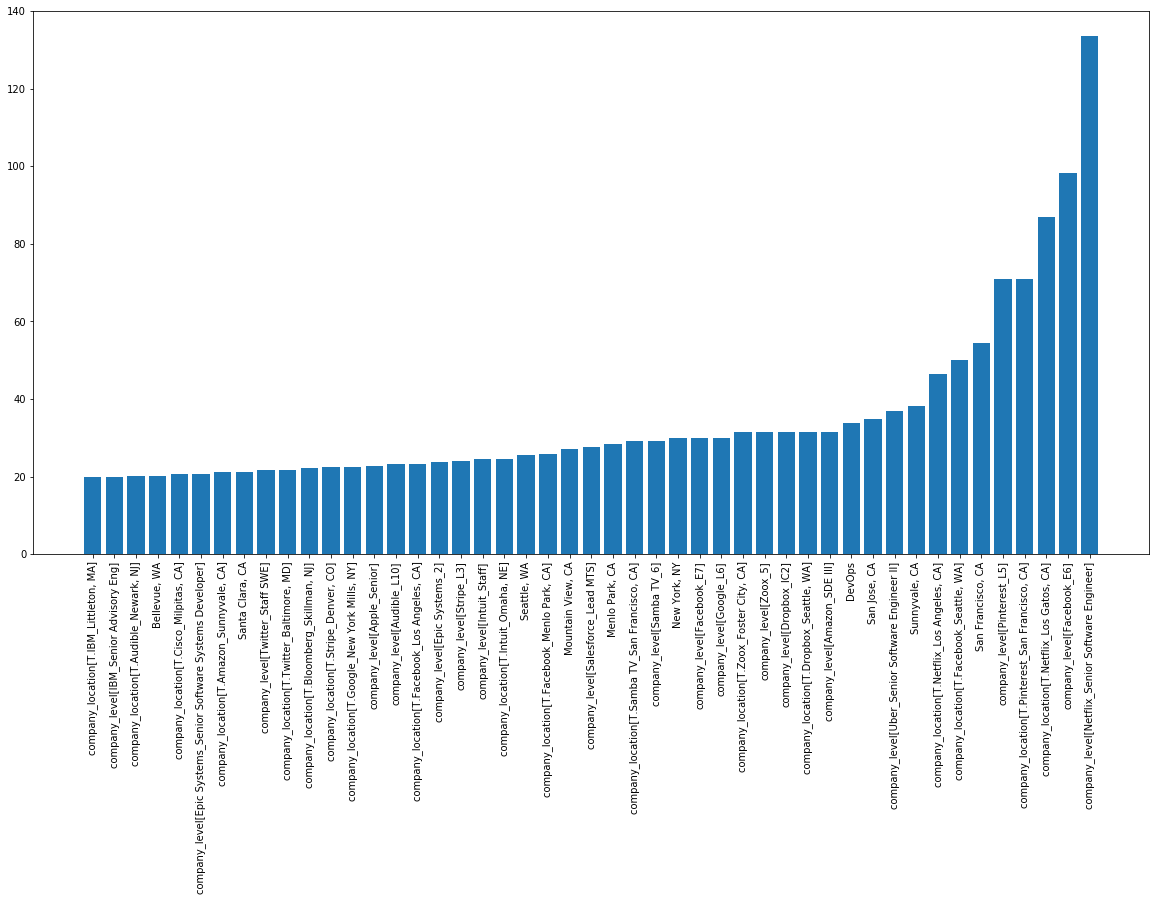

In [20]:
coefs = best_model_salary['coefs']

coefs_increase = best_model_salary['coefs'][best_model_salary['coefs'] > 20]
coefs_increase = coefs_increase.sort_values()
x = plt.bar(coefs_increase.index, coefs_increase)
x = plt.xticks(rotation=90)

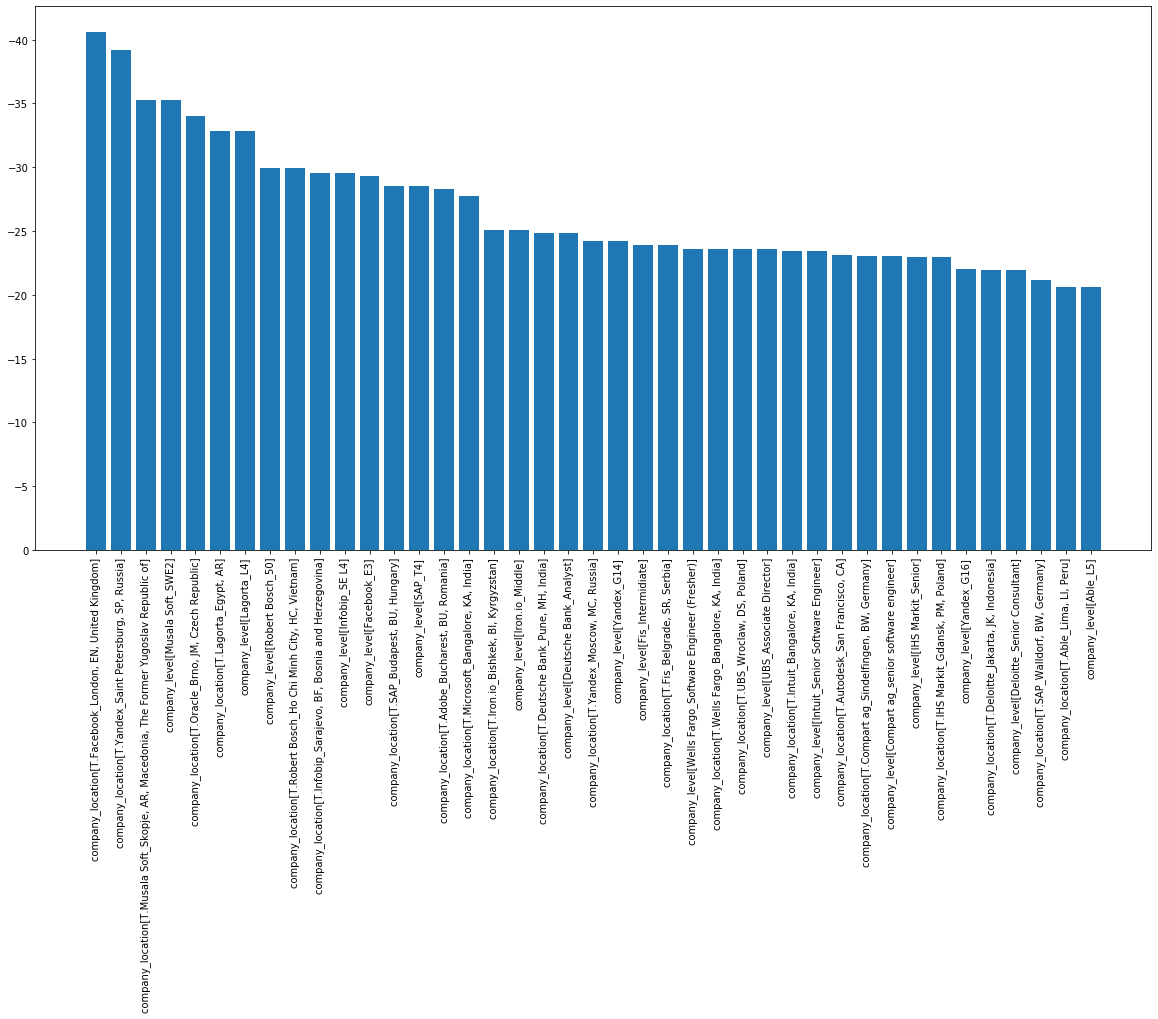

In [21]:
coefs_decrease = best_model_salary['coefs'][best_model_salary['coefs'] < -20]
coefs_decrease = coefs_decrease.sort_values()
x = plt.bar(coefs_decrease.index, coefs_decrease)
x = plt.xticks(rotation=90)
x = plt.gca().invert_yaxis()

In [22]:
coefs.filter(like='Google').sort_values().sort_index()
coefs.filter(like='Facebook').sort_values().sort_index()

company_level[Google_L3]                         -6.874307
company_level[Google_L4]                         13.314240
company_level[Google_L5]                         13.108882
company_level[Google_L6]                         29.929515
company_location[T.Google_Austin, TX]             7.913398
company_location[T.Google_Chicago, IL]            8.683186
company_location[T.Google_Kirkland, WA]          13.244212
company_location[T.Google_Los Angeles, CA]       10.602207
company_location[T.Google_Mountain View, CA]     11.235496
company_location[T.Google_New York Mills, NY]    22.365836
company_location[T.Google_San Francisco, CA]     -4.097961
company_location[T.Google_Seattle, WA]           -2.425222
company_location[T.Google_Sunnyvale, CA]         -6.213149
company_location[T.Google_Tokyo, TY, Japan]     -11.829672
dtype: float64

company_level[Facebook_E3]                                -29.327011
company_level[Facebook_E4]                                -13.181102
company_level[Facebook_E5]                                 -8.936577
company_level[Facebook_E6]                                 98.346579
company_level[Facebook_E7]                                 29.892260
company_location[T.Facebook_London, EN, United Kingdom]   -40.594704
company_location[T.Facebook_Los Angeles, CA]               23.319603
company_location[T.Facebook_Menlo Park, CA]                25.824820
company_location[T.Facebook_New York, NY]                  11.880327
company_location[T.Facebook_San Francisco, CA]              6.301356
company_location[T.Facebook_Seattle, WA]                   50.062747
dtype: float64

In [23]:
coefs.filter(like='San Fran').sort_values()
coefs.filter(like='NY').sort_values()

company_location[T.Autodesk_San Francisco, CA]        -23.124020
company_location[T.Yelp_San Francisco, CA]            -18.851290
company_location[T.Esurance_San Francisco, CA]        -14.217614
company_location[T.Dropbox_San Francisco, CA]         -11.382479
company_location[T.Zillow_San Francisco, CA]          -10.966669
company_location[T.Square_San Francisco, CA]           -8.661187
company_location[T.Instawork_San Francisco, CA]        -6.266652
company_location[T.Grid Dynamics_San Francisco, CA]    -6.117878
company_location[T.Dummy Company_San Francisco, CA]    -4.791187
company_location[T.Google_San Francisco, CA]           -4.097961
company_location[T.eBay_San Francisco, CA]             -1.199766
company_location[T.LiveRamp_San Francisco, CA]         -0.645795
company_location[T.Amazon_San Francisco, CA]           -0.580095
company_location[T.WeWork_San Francisco, CA]           -0.507776
company_location[T.Microsoft_San Francisco, CA]        -0.403819
company_location[T.Pocket

company_location[T.Amazon_New York, NY]               -18.560718
company_location[T.Animoto_New York, NY]               -9.277113
company_location[T.Headstrong_New York, NY]            -8.929349
company_location[T.Uber_New York, NY]                  -6.879896
company_location[T.IBM_New York, NY]                   -6.856210
company_location[T.Fohr_New York, NY]                  -6.294273
company_location[T.Capital One_New York, NY]           -5.996701
company_location[T.LinkedIn_New York, NY]              -4.340915
company_location[T.Citi_New York, NY]                  -3.621007
company_location[T.Goldman Sachs_New York, NY]         -2.509847
company_location[T.The New York Times_New York, NY]    -0.892025
company_location[T.UBS_New York, NY]                    0.707111
company_location[T.Twitter_New York, NY]                2.626163
company_location[T.eBay_New York, NY]                   3.677217
company_location[T.Turbonomic_New York, NY]             4.467678
company_location[T.Capsul